##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 1 - Prompting

Welcome to the Kaggle 5-day Generative AI course!

This notebook will show you how to get started with the Gemini API and walk you through some of the example prompts and techniques that you can also read about in the Prompting whitepaper. You don't need to read the whitepaper to use this notebook, but the papers will give you some theoretical context and background to complement this interactive notebook.


## Before you begin

In this notebook, you'll start exploring prompting using the Python SDK and AI Studio. For some inspiration, you might enjoy exploring some apps that have been built using the Gemini family of models. Here are a few that we like, and we think you will too.

* [TextFX](https://textfx.withgoogle.com/) is a suite of AI-powered tools for rappers, made in collaboration with Lupe Fiasco,
* [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) shows how you can talk directly to a database using the Gemini API,
* [NotebookLM](https://notebooklm.google/) uses Gemini models to build your own personal AI research assistant.


## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**

## New for Gemini 2.0!

This course material was first launched in November 2024. The AI and LLM space is moving incredibly fast, so we have made some updates to use the latest models and capabilities.

* These codelabs have been updated to use the Gemini 2.0 family of models.
* The Python SDK has been updated from `google-generativeai` to the new, unified [`google-genai`](https://pypi.org/project/google-genai) SDK.
  * This new SDK works with both the developer Gemini API as well as Google Cloud Vertex AI, and switching is [as simple as changing some fields](https://pypi.org/project/google-genai/#:~:text=.Client%28%29-,API%20Selection,-By%20default%2C%20the).
* New model capabilities have been added to the relevant codelabs, such as "thinking mode" in this lab.
* Day 1 includes a new [Evaluation codelab](https://www.kaggle.com/code/markishere/day-1-evaluation-and-structured-output).

## Get started with Kaggle notebooks

If this is your first time using a Kaggle notebook, welcome! You can read about how to use Kaggle notebooks [in the docs](https://www.kaggle.com/docs/notebooks).

First, you will need to phone verify your account at kaggle.com/settings.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_0.png)
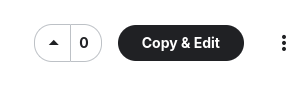
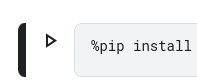

To run this notebook, as well as the others in this course, you will need to make a copy, or fork, the notebook. Look for the `Copy and Edit` button in the top-right, and **click it** to make an editable, private copy of the notebook. It should look like this one:

![Copy and Edit button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_1.png)

Your copy will now have a ▶️ **Run** button next to each code cell that you can press to execute that cell. These notebooks are expected to be run in order from top-to-bottom, but you are encouraged to add new cells, run your own code and explore. If you get stuck, you can try the `Factory reset` option in the `Run` menu, or head back to the original notebook and make a fresh copy.

![Run cell button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_2.png)

### Problems?

If you have any problems, head over to the [Kaggle Discord](https://discord.com/invite/kaggle), find the [`#5dgai-q-and-a` channel](https://discord.com/channels/1101210829807956100/1303438695143178251) and ask for help.

## Get started with the Gemini API

All of the exercises in this notebook will use the [Gemini API](https://ai.google.dev/gemini-api/) by way of the [Python SDK](https://pypi.org/project/google-genai/). Each of these prompts can be accessed directly in [Google AI Studio](https://aistudio.google.com/) too, so if you would rather use a web interface and skip the code for this activity, look for the <img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> AI Studio link on each prompt.

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_1.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_2.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_3.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_4.png)

### Install the SDK

In [2]:
!pip uninstall -qqy jupyterlab  # Remove unused packages from Kaggle's base image that conflict
!pip install -U -q "google-genai==1.7.0"

Import the SDK and some helpers for rendering the output.

In [3]:
from google import genai
from google.genai import types

from IPython.display import HTML, Markdown, display

Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.

In [4]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [5]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
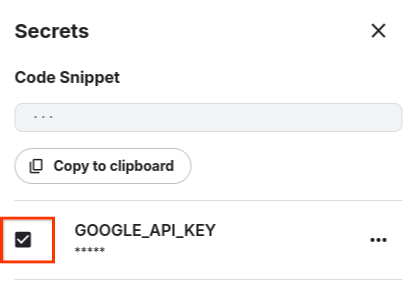

### Run your first prompt

In this step, you will test that your API key is set up correctly by making a request.

The Python SDK uses a [`Client` object](https://googleapis.github.io/python-genai/genai.html#genai.client.Client) to make requests to the API. The client lets you control which back-end to use (between the Gemini API and Vertex AI) and handles authentication (the API key).

The `gemini-2.0-flash` model has been selected here.

**Note**: If you see a `TransportError` on this step, you may need to **🔁 Factory reset** the notebook one time.

In [6]:
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Explain AI to me like I'm a kid.")

print(response.text)

Imagine you have a really, really smart toy robot.  That robot is like a super good learner.

Normally, you tell your toys exactly what to do. Like, "Walk forward, turn left, stop!"

But an AI robot is different!  You teach it by showing it lots and lots of examples. 

For example, if you want it to recognize cats, you show it thousands of pictures of cats!  You say, "This is a cat!  This is a cat!  This is also a cat!"

After seeing enough cats, the robot starts to learn what makes a cat a cat - pointy ears, whiskers, furry tail, etc.  

Then, if you show it a brand new picture, it can guess if it's a cat or not!  It's learned from all the examples you showed it.

That's what AI is! It's about making computers (or robots!) learn from examples so they can do smart things, like recognize cats, play games, or even help doctors find diseases!

It's like teaching a pet a trick, but with computers!



In [7]:
# Self
tmp_response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="아이에게 말하는 것처럼 AI를 설명해줘.")

print(tmp_response.text)

자, 우리 꼬마 친구야, 인공지능(AI)에 대해 얘기해볼까? 😊

AI는 마치 아주 똑똑한 컴퓨터 친구 같아. 이 친구는 사람들이 가르쳐주는 것을 배우고, 생각하고, 심지어 문제를 해결할 수도 있어!

**예를 들어볼게!**

*   **네가 좋아하는 강아지 사진을 보여주면:** AI는 "어, 이건 강아지구나!" 하고 알아볼 수 있어. 수많은 강아지 사진을 보고 배웠기 때문이지. 마치 네가 강아지 책을 많이 읽어서 강아지를 잘 아는 것처럼 말이야!
*   **네가 좋아하는 노래를 틀어주면:** AI는 네가 어떤 노래를 좋아하는지 기억하고, 다음에 또 비슷한 노래를 추천해줄 수 있어. 네 취향을 배우는 거지!
*   **엄마 아빠가 쓰는 내비게이션:** AI는 가장 빠른 길을 찾아주고, 교통 상황도 알려줘. 많은 정보를 빠르게 계산해서 똑똑하게 길을 안내하는 거야.

**AI는 어떻게 배우는 걸까?**

AI는 마치 스펀지처럼 많은 정보를 흡수해. 사람들이 엄청나게 많은 데이터(사진, 글, 숫자 등)를 AI에게 보여주면, AI는 그 데이터에서 패턴을 찾고 규칙을 배우는 거야.

**AI는 어디에 쓰일까?**

AI는 정말 많은 곳에 쓰여!

*   **로봇 청소기:** 스스로 집 안을 돌아다니며 청소를 해주지.
*   **스마트폰 음성 비서:** "헤이 빅스비!" 또는 "오케이 구글!" 하고 말하면 날씨를 알려주거나 음악을 틀어줘.
*   **병원:** 의사 선생님들이 병을 진단하고 치료하는 데 도움을 줘.
*   **게임:** 게임 속 캐릭터들이 더 똑똑하게 움직이고 반응하도록 만들어줘.

**AI는 마법일까?**

아니, AI는 마법이 아니야. 똑똑한 과학자들과 엔지니어들이 만든 특별한 프로그램일 뿐이야. 하지만 AI는 앞으로 우리 삶을 더 편리하고 재미있게 만들어줄 수 있는 멋진 기술이야!

**기억할 점!**

AI는 아직 배우고 있는 중이야. 가끔 실수를 하기도 하지만, 점점 더 똑똑해질 거야. 그리고 AI는 사람들을 돕기 위해 만들어졌다는 것을 기억해

The response often comes back in markdown format, which you can render directly in this notebook.

In [8]:
Markdown(response.text)

Imagine you have a really, really smart toy robot.  That robot is like a super good learner.

Normally, you tell your toys exactly what to do. Like, "Walk forward, turn left, stop!"

But an AI robot is different!  You teach it by showing it lots and lots of examples. 

For example, if you want it to recognize cats, you show it thousands of pictures of cats!  You say, "This is a cat!  This is a cat!  This is also a cat!"

After seeing enough cats, the robot starts to learn what makes a cat a cat - pointy ears, whiskers, furry tail, etc.  

Then, if you show it a brand new picture, it can guess if it's a cat or not!  It's learned from all the examples you showed it.

That's what AI is! It's about making computers (or robots!) learn from examples so they can do smart things, like recognize cats, play games, or even help doctors find diseases!

It's like teaching a pet a trick, but with computers!


In [9]:
# Self
temp_response = Markdown(response.text)
# print(temp_response)  # <IPython.core.display.Markdown object>
display(temp_response)

Imagine you have a really, really smart toy robot.  That robot is like a super good learner.

Normally, you tell your toys exactly what to do. Like, "Walk forward, turn left, stop!"

But an AI robot is different!  You teach it by showing it lots and lots of examples. 

For example, if you want it to recognize cats, you show it thousands of pictures of cats!  You say, "This is a cat!  This is a cat!  This is also a cat!"

After seeing enough cats, the robot starts to learn what makes a cat a cat - pointy ears, whiskers, furry tail, etc.  

Then, if you show it a brand new picture, it can guess if it's a cat or not!  It's learned from all the examples you showed it.

That's what AI is! It's about making computers (or robots!) learn from examples so they can do smart things, like recognize cats, play games, or even help doctors find diseases!

It's like teaching a pet a trick, but with computers!


### Start a chat

The previous example uses a single-turn, text-in/text-out structure, but you can also set up a multi-turn chat structure too.

In [10]:
chat = client.chats.create(model='gemini-2.0-flash', history=[])
response = chat.send_message('Hello! My name is Jae-min Hong.')
print(response.text)

Nice to meet you, Jae-min Hong! It's a pleasure to connect with you. Is there anything I can help you with today?



In [11]:
response = chat.send_message('Can you tell me something interesting about dinosaurs?')
print(response.text)

Okay, here's a fascinating fact about dinosaurs:

**While we often picture dinosaurs as green or brown, recent fossil evidence suggests many dinosaurs, including some types of raptors and ornithomimids, had feathers and even vibrant colors!**

Scientists have found fossilized melanosomes (pigment-containing structures) within dinosaur feathers. By analyzing these structures, they can infer what colors the dinosaurs likely were. This means some dinosaurs might have looked more like exotic birds than the scaly monsters we see in movies!

Isn't that cool? They could have been quite colorful and patterned, using their plumage for display, camouflage, or even thermoregulation.



While you have the `chat` object alive, the conversation state
persists. Confirm that by asking if it knows the user's name.

In [12]:
response = chat.send_message('Do you remember what my name is?')
print(response.text)

Yes, your name is Jae-min Hong.



In [13]:
# Self
# print(chat)  # <google.genai.chats.Chat object at 0x79cd9cf9aa70>
print(chat.__dict__)

{'_modules': <google.genai.models.Models object at 0x7fcebc8dd3c0>, '_model': 'gemini-2.0-flash', '_config': None, '_comprehensive_history': [UserContent(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text='Hello! My name is Jae-min Hong.')], role='user'), Content(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text="Nice to meet you, Jae-min Hong! It's a pleasure to connect with you. Is there anything I can help you with today?\n")], role='model'), UserContent(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text='Can you tell me something interesting about dinosaurs?')], role='user'), Content(parts=[Part(video

### Choose a model

The Gemini API provides access to a number of models from the Gemini model family. Read about the available models and their capabilities on the [model overview page](https://ai.google.dev/gemini-api/docs/models/gemini).

In this step you'll use the API to list all of the available models.

In [14]:
for model in client.models.list():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking

The [`models.list`](https://ai.google.dev/api/models#method:-models.list) response also returns additional information about the model's capabilities, like the token limits and supported parameters.

In [15]:
from pprint import pprint

for model in client.models.list():
  if model.name == 'models/gemini-2.0-flash':
    pprint(model.to_json_dict())
    break

{'description': 'Gemini 2.0 Flash',
 'display_name': 'Gemini 2.0 Flash',
 'input_token_limit': 1048576,
 'name': 'models/gemini-2.0-flash',
 'output_token_limit': 8192,
 'supported_actions': ['generateContent', 'countTokens'],
 'tuned_model_info': {},
 'version': '2.0'}


## Explore generation parameters



### Output length

When generating text with an LLM, the output length affects cost and performance. Generating more tokens increases computation, leading to higher energy consumption, latency, and cost.

To stop the model from generating tokens past a limit, you can specify the `max_output_tokens` parameter when using the Gemini API. Specifying this parameter does not influence the generation of the output tokens, so the output will not become more stylistically or textually succinct, but it will stop generating tokens once the specified length is reached. Prompt engineering may be required to generate a more complete output for your given limit.

In [16]:
from google.genai import types

short_config = types.GenerateContentConfig(max_output_tokens=200)

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a 1000 word essay on the importance of olives in modern society.')

print(response.text)

## The Humble Olive: A Cornerstone of Culture, Cuisine, and Modern Society

The olive, a small, unassuming fruit, has woven itself into the fabric of human civilization for millennia. From its humble origins in the Mediterranean basin, the olive has spread its branches across the globe, becoming more than just a foodstuff; it is a symbol of peace, prosperity, and cultural identity. Its importance in modern society is multifaceted, encompassing culinary traditions, health and wellness, economic stability, and even environmental considerations. This essay will explore the profound and enduring role of olives in shaping our world today.

Perhaps the most immediately recognizable aspect of the olive’s importance lies in its culinary applications. Olive oil, extracted from the fruit, is a cornerstone of the Mediterranean diet, a dietary pattern widely recognized for its health benefits and longevity-promoting qualities. From drizzling over salads and grilling vegetables to frying seafood an

In [17]:
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a short poem on the importance of olives in modern society.')

print(response.text)

From sun-drenched groves, a humble fruit,
The olive's journey, bearing loot.
No gold or gems, but pressed with care,
A liquid grace, beyond compare.

On salads bright, a savory gleam,
In tapenades, a waking dream.
An oil that heals, a flavor deep,
The modern palate, secrets keep.

So raise a glass, to emerald hue,
The olive's gift, forever new.
A taste of peace, a vibrant art,
A cornerstone of every heart.



Explore with your own prompts. Try a prompt with a restrictive output limit and then adjust the prompt to work within that limit.

In [18]:
# Self
short_config = types.GenerateContentConfig(max_output_tokens=500)

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='자기소개서를 500자 내외로 작성해줘. 나는 RAG 과정을 구현하는 것에 관심이 있어. 최근엔 경진대회에도 참여해서 리더보드 점수는 낮지만, 의미있는 실험들을 많이 했어.')

print(response.text)

## RAG 모델에 대한 뜨거운 열정, 끊임없는 성장 추구

저는 RAG(Retrieval-Augmented Generation) 모델의 무한한 가능성에 매료되어, 이 분야를 깊이 파고들며 꾸준히 성장하고 있는 개발자입니다. RAG 모델이 가진 정보 검색과 생성 능력의 결합은 사용자에게 더욱 풍부하고 정확한 정보를 제공할 수 있다는 점에서 큰 매력을 느꼈습니다.

최근에는 RAG 모델 관련 경진대회에 참여하며 이론적인 지식을 실제 문제 해결에 적용하는 경험을 쌓았습니다. 비록 리더보드에서 높은 순위를 기록하지는 못했지만, 다양한 데이터 전처리 방식, 임베딩 모델, 검색 알고리즘을 실험하며 값진 인사이트를 얻었습니다. 특히, 데이터의 특성을 고려한 최적의 임베딩 모델 선정, 검색 결과의 신뢰도를 높이기 위한 랭킹 알고리즘 개선, 생성 모델의 답변 품질 향상을 위한 프롬프트 엔지니어링 등 다양한 시도를 통해 RAG 모델의 성능을 극대화하는 방법을 고민했습니다.

경진대회 참여를 통해 얻은 경험은 RAG 모델의 작동 원리를 더욱 깊이 이해하고, 실제 서비스에 적용 가능한 기술적 노하우를 축적하는 데 큰 도움이 되었습니다. 앞으로도 RAG 모델에 대한 끊임없는 학습과 실험을 통해, 사용자에게 더욱 유용한 정보를 제공하는 RAG 시스템 개발에 기여하고 싶습니다. 저는 RAG 모델 분야의 전문가로 성장하기 위해 끊임없이 배우고 도전하며, 실력 향상을 위해 최선을 다할 것입니다.



### Temperature

Temperature controls the degree of randomness in token selection. Higher temperatures result in a higher number of candidate tokens from which the next output token is selected, and can produce more diverse results, while lower temperatures have the opposite effect, such that a temperature of 0 results in greedy decoding, selecting the most probable token at each step.

Temperature doesn't provide any guarantees of randomness, but it can be used to "nudge" the output somewhat.

In [19]:
high_temp_config = types.GenerateContentConfig(temperature=2.0)


for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=high_temp_config,
      contents='Pick a random colour... (respond in a single word)')

  if response.text:
    print(response.text, '-' * 25)

Azure
 -------------------------
Magenta.
 -------------------------
Azure
 -------------------------
Magenta
 -------------------------
Purple.
 -------------------------


Now try the same prompt with temperature set to zero. Note that the output is not completely deterministic, as other parameters affect token selection, but the results will tend to be more stable.

In [20]:
low_temp_config = types.GenerateContentConfig(temperature=0.0)

for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=low_temp_config,
      contents='Pick a random colour... (respond in a single word)')

  if response.text:
    print(response.text, '-' * 25)

Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------


In [21]:
# Self
low_temp_config = types.GenerateContentConfig(temperature=0.5)

for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=low_temp_config,
      contents='Pick a random colour... (respond in a single word)')

  if response.text:
    print(response.text, '-' * 25)

Turquoise
 -------------------------
Turquoise
 -------------------------
Orange
 -------------------------
Turquoise
 -------------------------
Azure
 -------------------------


### Top-P

Like temperature, the top-P parameter is also used to control the diversity of the model's output.

Top-P defines the probability threshold that, once cumulatively exceeded, tokens stop being selected as candidates. A top-P of 0 is typically equivalent to greedy decoding, and a top-P of 1 typically selects every token in the model's vocabulary.

You may also see top-K referenced in LLM literature. Top-K is not configurable in the Gemini 2.0 series of models, but can be changed in older models. Top-K is a positive integer that defines the number of most probable tokens from which to select the output token. A top-K of 1 selects a single token, performing greedy decoding.


Run this example a number of times, change the settings and observe the change in output.

In [22]:
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=1.0,
    top_p=0.95,
)

story_prompt = "You are a creative writer. Write a short story about a cat who goes on an adventure."
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

Jasper was, by all accounts, a creature of comfort. His life revolved around sunbeams, the soft caress of Mrs. Higgins’ hand, and the precise allocation of his nine daily naps. His entire world was contained within the cozy confines of Number 12, Primrose Lane. Until, that is, the robin started singing.

This wasn’t just any robin. This robin, with its audacious chirp and flirtatious hops on the window ledge, whispered of a world beyond Jasper's pampered existence. It spoke of rustling leaves, of chasing butterflies, of the wild, untamed scent of damp earth. Jasper, a cat who had previously considered a dust bunny under the sofa a formidable challenge, felt a tremor of something unknown stirring within his feline heart.

One particularly warm morning, as Mrs. Higgins was distracted by a particularly juicy episode of her favorite soap opera, Jasper saw his opportunity. He nudged the slightly ajar back door with his nose, and with a surge of adrenaline, pushed it open.

The world explode

In [23]:
# Self
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=0.1,
    top_p=0.95,
)

story_prompt = "You are a creative writer. Write a short story about a cat who goes on an adventure."
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

Clementine, a calico of discerning tastes and a perpetually unimpressed expression, considered her life utterly predictable. Sunbeam naps, chasing dust bunnies, the occasional disdainful glance at the goldfish – it was all rather…beige. She yearned for something more, a splash of vibrant color in her monochrome existence.

One blustery autumn afternoon, the back door, usually bolted tighter than a miser's purse, was ajar. A tantalizing gust of wind, carrying the scent of damp earth and decaying leaves, beckoned. Clementine, abandoning her nap mid-yawn, crept towards the opening.

The world outside was a riot of sensory overload. Towering trees, their leaves ablaze in fiery hues, rustled secrets in the wind. Squirrels, plump and frantic, darted across the lawn, burying treasures. Clementine, emboldened by the novelty, slipped through the gap and into the unknown.

Her adventure began with a perilous journey across the lawn, dodging rogue acorns and the judgmental stares of a robin perch

In [24]:
# Self
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=0.1,
    top_p=0.95,
)

story_prompt = "You are a creative writer. Write a short story about a cat who goes on an adventure."
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

Clementine, a calico of discerning tastes and a perpetually unimpressed expression, considered her life utterly predictable. Sunbeam naps, chasing dust bunnies, the occasional disdainful glance at the goldfish – it was all rather…beige. Then, the wind changed.

Not just any wind, mind you. This wind, whistling through the slightly ajar kitchen window, carried the scent of pine needles, damp earth, and something wild, something untamed. It tickled Clementine’s whiskers and stirred a dormant yearning deep within her feline soul.

She leaped onto the windowsill, her tail twitching. The world outside, usually a blur of passing cars and the neighbor’s yappy chihuahua, suddenly shimmered with possibility. The wind whispered promises of rustling leaves, scurrying creatures, and adventures beyond the confines of her perfectly curated indoor life.

Clementine, against all her better judgment, squeezed through the window.

The backyard was a jungle compared to her living room. Towering sunflower

## Prompting

This section contains some prompts from the chapter for you to try out directly in the API. Try changing the text here to see how each prompt performs with different instructions, more examples, or any other changes you can think of.

### Zero-shot

Zero-shot prompts are prompts that describe the request for the model directly.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [25]:
model_config = types.GenerateContentConfig(
    temperature=0.1,
    top_p=1,
    max_output_tokens=5,
)

zero_shot_prompt = """Classify movie reviews as POSITIVE, NEUTRAL or NEGATIVE.
Review: "Her" is a disturbing study revealing the direction
humanity is headed if AI is allowed to keep evolving,
unchecked. I wish there were more movies like this masterpiece.
Sentiment: """

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=zero_shot_prompt)

print(response.text)

POSITIVE



#### Enum mode

The models are trained to generate text, and while the Gemini 2.0 models are great at following instructions, other models can sometimes produce more text than you may wish for. In the preceding example, the model will output the label, but sometimes it can include a preceding "Sentiment" label, and without an output token limit, it may also add explanatory text afterwards. See [this prompt in AI Studio](https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g) for an example.

The Gemini API has an [Enum mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Enum.ipynb) feature that allows you to constrain the output to a fixed set of values.

In [26]:
import enum

class Sentiment(enum.Enum):
    POSITIVE = "positive"
    NEUTRAL = "neutral"
    NEGATIVE = "negative"


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=Sentiment
    ),
    contents=zero_shot_prompt)

print(response.text)

positive


In [27]:
# Self
zero_shot_prompt = """Classify emails as POSITIVE, NEUTRAL or NEGATIVE.
Email: 안녕하세요, Jae-min Hong 님!
DACON 경진대회 운영진입니다.
최종 2차 평가 안내를 공지드립니다.
자세한 사항은 토크를 확인해 주세요.
Sentiment: """

class Sentiment(enum.Enum):
    POSITIVE = "정상 메일"
    NEUTRAL = "분류 불가능"
    NEGATIVE = "스팸 메일"


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=Sentiment
    ),
    contents=zero_shot_prompt)

print(response.text)

정상 메일


In [28]:
# Self
zero_shot_prompt = """Classify emails as POSITIVE, NEUTRAL or NEGATIVE.
Email: 안녕하세요, Jae-min Hong 님!
DACON 경진대회 운영진입니다.
최종 2차 평가 안내를 공지드립니다.
자세한 사항은 토크를 확인해 주세요.
두근두근!! 결과는?
Sentiment: """

class Sentiment(enum.Enum):
    POSITIVE = "정상 메일"
    NEUTRAL = "분류 불가능"
    NEGATIVE = "스팸 메일"


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=Sentiment
    ),
    contents=zero_shot_prompt)

print(response.text)

분류 불가능


In [29]:
# Self
zero_shot_prompt = """Classify emails as POSITIVE, NEUTRAL or NEGATIVE.
Email: 안녕하세요, Jae-min Hong 님!
두근두근!! 당첨 결과는?
아래 링크로 바로 접속하세요!
Sentiment: """

class Sentiment(enum.Enum):
    POSITIVE = "정상 메일"
    NEUTRAL = "분류 불가능"
    NEGATIVE = "스팸 메일"


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=Sentiment
    ),
    contents=zero_shot_prompt)

print(response.text)

스팸 메일


When using constrained output like an enum, the Python SDK will attempt to convert the model's text response into a Python object automatically. It's stored in the `response.parsed` field.

In [30]:
enum_response = response.parsed
print(enum_response)
print(type(enum_response))

Sentiment.NEGATIVE
<enum 'Sentiment'>


### One-shot and few-shot

Providing an example of the expected response is known as a "one-shot" prompt. When you provide multiple examples, it is a "few-shot" prompt.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1jjWkjUSoMXmLvMJ7IzADr_GxHPJVV2bg"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [31]:
few_shot_prompt = """Parse a customer's pizza order into valid JSON:

EXAMPLE:
I want a small pizza with cheese, tomato sauce, and pepperoni.
JSON Response:
```
{
"size": "small",
"type": "normal",
"ingredients": ["cheese", "tomato sauce", "pepperoni"]
}
```

EXAMPLE:
Can I get a large pizza with tomato sauce, basil and mozzarella
JSON Response:
```
{
"size": "large",
"type": "normal",
"ingredients": ["tomato sauce", "basil", "mozzarella"]
}
```

ORDER:
"""

customer_order = "Give me a large with cheese & pineapple"

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=250,
    ),
    contents=[few_shot_prompt, customer_order])

print(response.text)

```json
{
"size": "large",
"type": "normal",
"ingredients": ["cheese", "pineapple"]
}
```



#### JSON mode

To provide control over the schema, and to ensure that you only receive JSON (with no other text or markdown), you can use the Gemini API's [JSON mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/JSON_mode.ipynb). This forces the model to constrain decoding, such that token selection is guided by the supplied schema.

In [32]:
import typing_extensions as typing

class PizzaOrder(typing.TypedDict):
    size: str
    ingredients: list[str]
    type: str


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=PizzaOrder,
    ),
    contents="Can I have a large dessert pizza with apple and chocolate")

print(response.text)

{
  "size": "large",
  "ingredients": ["apple", "chocolate"],
  "type": "dessert pizza"
}


In [33]:
# Self
class DessertOrder(typing.TypedDict):
    productName: list[str]
    productCount: list[int]
    notProduct: list[str]
    type: str

system_prompt = """이 매장은 제과, 제빵을 판매하는 가게입니다.

손님의 구매 요청 사항을 정확히 파악하세요.
- 판매하는 제품의 여부를 확인하세요.
    - 제과, 제빵에 해당하면 판매할 수 있습니다.
    - 완성품인 제과, 제빵이 아니라면 판매할 수 없습니다.
    - 판매하는 제품의 수량을 확인하세요.
- 판매하지 않는 제품은 제외해 주세요."""

customer_order = """안녕하세요!
플레인 휘낭시에 2개, 소금 초코 휘낭시에 1개, 메이플 호두 휘낭시에 2개 주세요.
아 그리고 통밀 식빵 한 봉지, 버터 1개, 계란 한 판도 살게요.
음.. 옥수수 바스크 치즈 케이크 1개, 딸기 생크림 케이크 1개도 추가할게요!"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=DessertOrder,
    ),
    contents=[system_prompt, customer_order])

print(response.text)

{
  "productName": ["플레인 휘낭시에", "소금 초코 휘낭시에", "메이플 호두 휘낭시에", "통밀 식빵", "옥수수 바스크 치즈 케이크", "딸기 생크림 케이크"],
  "productCount": [2, 1, 2, 1, 1, 1],
  "notProduct": ["버터", "계란"],
  "type": "제과/제빵"
}


### Chain of Thought (CoT)

Direct prompting on LLMs can return answers quickly and (in terms of output token usage) efficiently, but they can be prone to hallucination. The answer may "look" correct (in terms of language and syntax) but is incorrect in terms of factuality and reasoning.

Chain-of-Thought prompting is a technique where you instruct the model to output intermediate reasoning steps, and it typically gets better results, especially when combined with few-shot examples. It is worth noting that this technique doesn't completely eliminate hallucinations, and that it tends to cost more to run, due to the increased token count.

Models like the Gemini family are trained to be "chatty" or "thoughtful" and will provide reasoning steps without prompting, so for this simple example you can ask the model to be more direct in the prompt to force a non-reasoning response. Try re-running this step if the model gets lucky and gets the answer correct on the first try.

In [34]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now, I
am 20 years old. How old is my partner? Return the answer directly."""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

print(response.text)

48



Now try the same approach, but indicate to the model that it should "think step by step".

In [35]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now,
I am 20 years old. How old is my partner? Let's think step by step."""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

Markdown(response.text)

Here's how to solve this:

1. **Find the age difference:** When you were 4, your partner was 3 * 4 = 12 years old.
2. **Calculate the age difference:** This means your partner is 12 - 4 = 8 years older than you.
3. **Calculate the partner's current age:** Since your partner is 8 years older than you, they are currently 20 + 8 = 28 years old.

**Answer:** Your partner is 28 years old.


In [36]:
# Self
prompt = """사과가 5개가 있고, 오렌지가 3개가 있어. 
나는 사과와 오렌지를 각각 1개 씩 먹었어. 
그리고 한 팩에 15개인 딸기를 구매한다면, 과일은 총 몇 개가 될까?
단계별로 생각해!"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

Markdown(response.text)

자, 단계를 따라 차근차근 생각해 봅시다.

1. **처음 가지고 있던 과일:**
   * 사과: 5개
   * 오렌지: 3개
   * 총합: 5 + 3 = 8개

2. **먹은 과일:**
   * 사과: 1개
   * 오렌지: 1개
   * 총합: 1 + 1 = 2개

3. **남은 과일:**
   * 사과: 5 - 1 = 4개
   * 오렌지: 3 - 1 = 2개
   * 총합: 4 + 2 = 6개

4. **새로 산 딸기:**
   * 딸기: 15개

5. **최종 과일 개수:**
   * 남은 사과, 오렌지: 6개
   * 새로 산 딸기: 15개
   * 총합: 6 + 15 = 21개

따라서, 과일은 총 **21개**가 됩니다.

### ReAct: Reason and act

In this example you will run a ReAct prompt directly in the Gemini API and perform the searching steps yourself. As this prompt follows a well-defined structure, there are frameworks available that wrap the prompt into easier-to-use APIs that make tool calls automatically, such as the LangChain example from the "Prompting" whitepaper.

To try this out with the Wikipedia search engine, check out the [Searching Wikipedia with ReAct](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) cookbook example.


> Note: The prompt and in-context examples used here are from [https://github.com/ysymyth/ReAct](https://github.com/ysymyth/ReAct) which is published under an [MIT license](https://opensource.org/licenses/MIT), Copyright (c) 2023 Shunyu Yao.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/18oo63Lwosd-bQ6Ay51uGogB3Wk3H8XMO"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [37]:
model_instructions = """
Solve a question answering task with interleaving Thought, Action, Observation steps. Thought can reason about the current situation,
Observation is understanding relevant information from an Action's output and Action can be one of three types:
 (1) <search>entity</search>, which searches the exact entity on Wikipedia and returns the first paragraph if it exists. If not, it
     will return some similar entities to search and you can try to search the information from those topics.
 (2) <lookup>keyword</lookup>, which returns the next sentence containing keyword in the current context. This only does exact matches,
     so keep your searches short.
 (3) <finish>answer</finish>, which returns the answer and finishes the task.
"""

example1 = """Question
Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?

Thought 1
The question simplifies to "The Simpsons" character Milhouse is named after who. I only need to search Milhouse and find who it is named after.

Action 1
<search>Milhouse</search>

Observation 1
Milhouse Mussolini Van Houten is a recurring character in the Fox animated television series The Simpsons voiced by Pamela Hayden and created by Matt Groening.

Thought 2
The paragraph does not tell who Milhouse is named after, maybe I can look up "named after".

Action 2
<lookup>named after</lookup>

Observation 2
Milhouse was named after U.S. president Richard Nixon, whose middle name was Milhous.

Thought 3
Milhouse was named after U.S. president Richard Nixon, so the answer is Richard Nixon.

Action 3
<finish>Richard Nixon</finish>
"""

example2 = """Question
What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?

Thought 1
I need to search Colorado orogeny, find the area that the eastern sector of the Colorado orogeny extends into, then find the elevation range of the area.

Action 1
<search>Colorado orogeny</search>

Observation 1
The Colorado orogeny was an episode of mountain building (an orogeny) in Colorado and surrounding areas.

Thought 2
It does not mention the eastern sector. So I need to look up eastern sector.

Action 2
<lookup>eastern sector</lookup>

Observation 2
The eastern sector extends into the High Plains and is called the Central Plains orogeny.

Thought 3
The eastern sector of Colorado orogeny extends into the High Plains. So I need to search High Plains and find its elevation range.

Action 3
<search>High Plains</search>

Observation 3
High Plains refers to one of two distinct land regions

Thought 4
I need to instead search High Plains (United States).

Action 4
<search>High Plains (United States)</search>

Observation 4
The High Plains are a subregion of the Great Plains. From east to west, the High Plains rise in elevation from around 1,800 to 7,000 ft (550 to 2,130m).

Thought 5
High Plains rise in elevation from around 1,800 to 7,000 ft, so the answer is 1,800 to 7,000 ft.

Action 5
<finish>1,800 to 7,000 ft</finish>
"""

# Come up with more examples yourself, or take a look through https://github.com/ysymyth/ReAct/

To capture a single step at a time, while ignoring any hallucinated Observation steps, you will use `stop_sequences` to end the generation process. The steps are `Thought`, `Action`, `Observation`, in that order.

In [38]:
question = """Question
Who was the youngest author listed on the transformers NLP paper?
"""

# You will perform the Action; so generate up to, but not including, the Observation.
react_config = types.GenerateContentConfig(
    stop_sequences=["\nObservation"],
    system_instruction=model_instructions + example1 + example2,
)

# Create a chat that has the model instructions and examples pre-seeded.
react_chat = client.chats.create(
    model='gemini-2.0-flash',
    config=react_config,
)

resp = react_chat.send_message(question)
print(resp.text)

Thought 1
I need to find the transformers NLP paper and then find the list of authors, then determine which author is the youngest.

Action 1
<search>transformers NLP paper</search>



Now you can perform this research yourself and supply it back to the model.

In [39]:
observation = """Observation 1
[1706.03762] Attention Is All You Need
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
"""
resp = react_chat.send_message(observation)
print(resp.text)

Thought 2
The authors are Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin. I need to search each one to find their birthdate, and determine who is the youngest.

Action 2
<search>Ashish Vaswani</search>



This process repeats until the `<finish>` action is reached. You can continue running this yourself if you like, or try the [Wikipedia example](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) to see a fully automated ReAct system at work.

## Thinking mode

The experiemental Gemini Flash 2.0 "Thinking" model has been trained to generate the "thinking process" the model goes through as part of its response. As a result, the Flash Thinking model is capable of stronger reasoning capabilities in its responses.

Using a "thinking mode" model can provide you with high-quality responses without needing specialised prompting like the previous approaches. One reason this technique is effective is that you induce the model to generate relevant information ("brainstorming", or "thoughts") that is then used as part of the context in which the final response is generated.

Note that when you use the API, you get the final response from the model, but the thoughts are not captured. To see the intermediate thoughts, try out [the thinking mode model in AI Studio](https://aistudio.google.com/prompts/new_chat?model=gemini-2.0-flash-thinking-exp-01-21).

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1Z991SV7lZZZqioOiqIUPv9a9ix-ws4zk"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [40]:
import io
from IPython.display import Markdown, clear_output


response = client.models.generate_content_stream(
    model='gemini-2.0-flash-thinking-exp',
    contents='Who was the youngest author listed on the transformers NLP paper?',
)

buf = io.StringIO()
for chunk in response:
    buf.write(chunk.text)
    # Display the response as it is streamed
    print(chunk.text, end='')

# And then render the finished response as formatted markdown.
clear_output()
Markdown(buf.getvalue())

The youngest author listed on the "Attention is All You Need" paper, which introduced the Transformer architecture, is **Aidan N. Gomez**.

While precise birthdates for all authors may not be readily available publicly, Aidan N. Gomez was a PhD student at the University of Toronto at the time of the paper's publication in 2017.  This generally indicates he would be the youngest among the authors, who were mostly researchers at Google Brain or other established institutions.

To confirm, biographical information and online presence (like LinkedIn, university pages, etc.) for the authors generally support this, placing Aidan N. Gomez as the youngest based on typical academic career trajectories.

## Code prompting

### Generating code

The Gemini family of models can be used to generate code, configuration and scripts. Generating code can be helpful when learning to code, learning a new language or for rapidly generating a first draft.

It's important to be aware that since LLMs can make mistakes, and can repeat training data, it's essential to read and test your code first, and comply with any relevant licenses.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1YX71JGtzDjXQkgdes8bP6i3oH5lCRKxv"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [41]:
# The Gemini models love to talk, so it helps to specify they stick to the code if that
# is all that you want.
code_prompt = """
Write a Python function to calculate the factorial of a number. No explanation, provide only the code.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=1,
        top_p=1,
        max_output_tokens=1024,
    ),
    contents=code_prompt)

Markdown(response.text)

```python
def factorial(n):
  if n == 0:
    return 1
  else:
    return n * factorial(n-1)
```

### Code execution

The Gemini API can automatically run generated code too, and will return the output.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/11veFr_VYEwBWcLkhNLr-maCG0G8sS_7Z"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [42]:
from pprint import pprint

config = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
)

code_exec_prompt = """
Generate the first 14 odd prime numbers, then calculate their sum.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=config,
    contents=code_exec_prompt)

for part in response.candidates[0].content.parts:
  pprint(part.to_json_dict())
  print("-----")

{'text': "Okay, I can do that. First, I'll generate the first 14 odd prime "
         'numbers. Remember that a prime number is a number greater than 1 '
         'that has only two factors: 1 and itself. Since we want *odd* prime '
         'numbers, we exclude 2 from the list. After generating those numbers, '
         'I will sum them.\n'
         '\n'}
-----
{'executable_code': {'code': 'primes = []\n'
                             'num = 3\n'
                             'while len(primes) < 14:\n'
                             '    is_prime = True\n'
                             '    for i in range(2, int(num**0.5) + 1):\n'
                             '        if num % i == 0:\n'
                             '            is_prime = False\n'
                             '            break\n'
                             '    if is_prime:\n'
                             '        primes.append(num)\n'
                             '    num += 2\n'
                             '\n'
   

This response contains multiple parts, including an opening and closing text part that represent regular responses, an `executable_code` part that represents generated code and a `code_execution_result` part that represents the results from running the generated code.

You can explore them individually.

In [43]:
for part in response.candidates[0].content.parts:
    if part.text:
        display(Markdown(part.text))
    elif part.executable_code:
        display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    elif part.code_execution_result:
        if part.code_execution_result.outcome != 'OUTCOME_OK':
            display(Markdown(f'## Status {part.code_execution_result.outcome}'))

        display(Markdown(f'```\n{part.code_execution_result.output}\n```'))

Okay, I can do that. First, I'll generate the first 14 odd prime numbers. Remember that a prime number is a number greater than 1 that has only two factors: 1 and itself. Since we want *odd* prime numbers, we exclude 2 from the list. After generating those numbers, I will sum them.



```python
primes = []
num = 3
while len(primes) < 14:
    is_prime = True
    for i in range(2, int(num**0.5) + 1):
        if num % i == 0:
            is_prime = False
            break
    if is_prime:
        primes.append(num)
    num += 2

print(f'{primes=}')

sum_of_primes = sum(primes)
print(f'{sum_of_primes=}')

```

```
primes=[3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
sum_of_primes=326

```

The first 14 odd prime numbers are 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, and 47. Their sum is 326.


### Explaining code

The Gemini family of models can explain code to you too. In this example, you pass a [bash script](https://github.com/magicmonty/bash-git-prompt) and ask some questions.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1N7LGzWzCYieyOf_7bAG4plrmkpDNmUyb"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [44]:
file_contents = !curl https://raw.githubusercontent.com/magicmonty/bash-git-prompt/refs/heads/master/gitprompt.sh

explain_prompt = f"""
Please explain what this file does at a very high level. What is it, and why would I use it?

```
{file_contents}
```
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=explain_prompt)

Markdown(response.text)

This is a shell script (likely for Bash or Zsh) designed to enhance your command-line prompt with information about the current Git repository.  It's often referred to as a "Git prompt."

**What it does:**

*   **Displays Git Status:** Shows you the current branch, whether there are uncommitted changes (staged, unstaged, untracked), if you're ahead/behind the remote branch, and other relevant Git information directly in your command prompt.
*   **Customizable:** Allows you to configure the colors, symbols, and information displayed in the prompt to match your preferences.  It supports themes to easily switch between different styles.
*   **Asynchronous Fetching:**  Can fetch remote branch information in the background, so your prompt doesn't lag while waiting for network operations.
*   **Virtual Environment Integration:** Can display information about the active Python virtual environment (if any).
*   **Cross-Shell Compatibility:** It contains logic to work with both Bash and Zsh shells.

**Why you would use it:**

*   **Stay Informed:** Quickly see the status of your Git repository without having to run `git status` every time.
*   **Improve Workflow:** Makes it easier to track changes, branches, and the overall state of your Git projects.
*   **Personalize Your Terminal:** Customize the look and feel of your command prompt to make it more visually appealing and informative.

In essence, this script aims to provide a convenient and visually informative way to keep track of your Git repositories directly within your command-line environment. You would use it by sourcing this script in your `.bashrc` or `.zshrc` file so that it gets executed every time you start a new terminal session.


## Learn more

To learn more about prompting in depth:

* Check out the whitepaper issued with today's content,
* Try out the apps listed at the top of this notebook ([TextFX](https://textfx.withgoogle.com/), [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) and [NotebookLM](https://notebooklm.google/)),
* Read the [Introduction to Prompting](https://ai.google.dev/gemini-api/docs/prompting-intro) from the Gemini API docs,
* Explore the Gemini API's [prompt gallery](https://ai.google.dev/gemini-api/prompts) and try them out in AI Studio,
* Check out the Gemini API cookbook for [inspirational examples](https://github.com/google-gemini/cookbook/blob/main/examples/) and [educational quickstarts](https://github.com/google-gemini/cookbook/blob/main/quickstarts/).

Be sure to check out the codelabs on day 3 too, where you will explore some more advanced prompting with code execution.

And please share anything exciting you have tried in the Discord!

*- [Mark McD](https://linktr.ee/markmcd)*